In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./NR/V2L_NR_L23_filter.h5ad')
dr = sc.read_h5ad('./DR/V2L_DR_L23_filter.h5ad')

In [34]:
adata = sc.AnnData.concatenate(nr,dr,batch_categories=('NR','DR'),batch_key='cond')
adata.write_h5ad('./NR_DR_V2L_L23_filter_merge.h5ad')

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_62803/3207450404.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = sc.AnnData.concatenate(nr,dr,batch_categories=('NR','DR'),batch_key='cond')


In [35]:
adata.obs

,n_genes,n_counts,doublet_score,Sample,Class,Subclass,Subtype,Ann_subclass_cell,Type,cond
AAACGAAAGAAGCGCT-1-V2L_1-NR,579,762.0,0.021762,V2L_1,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGAACAGGTACGA-1-V2L_1-NR,1459,2697.0,0.040264,V2L_1,Glut,L2/3 IT CTX,Type C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,NR
AAACGAAGTAATTAGG-1-V2L_1-NR,1593,2891.0,0.053322,V2L_1,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
AAACGAATCTCGGCTT-1-V2L_1-NR,1286,2179.0,0.022246,V2L_1,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGCTCACCTTCCA-1-V2L_1-NR,1144,1933.0,0.072668,V2L_1,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGATCG-1-V2L_2-DR,1854,3630.0,0.028843,V2L_2,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,DR
TTTGGTTGTTCACGAT-1-V2L_2-DR,2420,5707.0,0.098200,V2L_2,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR
TTTGTTGCACTCTGCT-1-V2L_2-DR,2026,4249.0,0.039651,V2L_2,Glut,L2/3 IT CTX,Type C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,DR
TTTGTTGCAGCTTTGA-1-V2L_2-DR,2385,5681.0,0.024654,V2L_2,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR


In [3]:
from matplotlib import gridspec
import xgboost as xgb
from sklearn.metrics import confusion_matrix, adjusted_rand_score, roc_curve, auc, classification_report, f1_score, cohen_kappa_score
import plotly.graph_objects as go
from itertools import cycle, islice
from sklearn.preprocessing import label_binarize

#Defining class that contains functions that will perform the mapping with XGBoost and plot the results
class TimeMapping():
    
    # xgbclassifier will run the feature selection, training and validation, and testing
    def xgbclassifier(
        self,
        train_anndata,
        test_anndata,
        train_dict,
        test_dict,
        max_cells_per_ident = 700,
        train_frac = 0.7
        ): 

        self.train_dict = train_dict
        self.test_dict = test_dict

        self.numbertrainclasses = len(set(train_anndata.obs.Type))
        self.numbertestclasses = len(set(test_anndata.obs.Type))

        #Splitting the cell barcodes into a training set and validation set based on the minimum of 70% of cells or 700 cells
        #Creating array of the labels for each cell (the Type each cell barcode belongs too)
        training_set_train = []
        training_label_train = []

        for i in set(train_anndata.obs.Type):
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train = np.hstack([training_set_train,train_temp])
            training_label_train = np.hstack([training_label_train,np.repeat(train_dict[i],len(train_temp))])

        training_set_test = []
        training_label_test = []

        for i in set(test_anndata.obs.Type):
            cells_in_clust = test_anndata.obs.index[test_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_test = np.hstack([training_set_test,train_temp])
            training_label_test = np.hstack([training_label_test,np.repeat(test_dict[i],len(train_temp))])

        train_index_train = []
        for i in training_set_train:
            train_index_train.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_index_test = []
        for i in training_set_test:
            train_index_test.append(np.where(test_anndata.obs.index.values == i)[0][0])

        train_matrix_train = xgb.DMatrix(data = train_anndata.X.A[train_index_train,:], label = training_label_train, feature_names = list(train_anndata.var.index.values))

        train_matrix_test = xgb.DMatrix(data = test_anndata.X.A[train_index_test,:], label = training_label_test, feature_names = list(test_anndata.var.index.values))

        del training_set_train, training_label_train, training_set_test, training_label_test, train_index_train, train_index_test

        #Defining parameters for the XGBoost Model
        xgb_params_train = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertrainclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the training data
        bst_model_train = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train,
            num_boost_round = nround)

        xgb_params_test = {
            'objective':'multi:softprob',
            'eval_metric':'mlogloss',
            'num_class':self.numbertestclasses,
            'eta':0.2,
            'max_depth':6,
            'subsample': 0.6}
        nround = 200

        #Fitting the XGBoost Model to the testing data
        bst_model_test = xgb.train(
            params = xgb_params_test,
            dtrain = train_matrix_test,
            num_boost_round = nround)

        train_xgboost_scores = bst_model_train.get_score(importance_type="gain")
        sort_train_scores = {k: v for k, v in sorted(train_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestrain = list(sort_train_scores.keys())

        test_xgboost_scores = bst_model_test.get_score(importance_type="gain")
        sort_test_scores = {k: v for k, v in sorted(test_xgboost_scores.items(), key=lambda item: item[1], reverse = True)[:500]}
        top500genestest = list(sort_test_scores.keys())

        common_top_genes = np.array([i for i in top500genestrain if i in top500genestest]) #These are the features that we will use for training, validating and testing

        del train_matrix_train, train_matrix_test, bst_model_train, bst_model_test, train_xgboost_scores, sort_train_scores, top500genestrain, test_xgboost_scores, sort_test_scores, top500genestest

        #Train XGBoost on 70% of training data and validate on the remaining data
        common_top_genes_index_train = []
        for i in common_top_genes:
            common_top_genes_index_train.append(np.where(train_anndata.var.index.values == i)[0][0])

        training_set_train_70 = []
        validation_set_train_70 = []
        training_label_train_70 = []
        validation_label_train_70 = []

        for i in set(train_anndata.obs.Type):
            cells_in_clust = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            n = min(max_cells_per_ident,round(len(cells_in_clust)*train_frac))
            train_temp = np.random.choice(cells_in_clust,n,replace = False)
            validation_temp = np.setdiff1d(cells_in_clust, train_temp)
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_70 = np.hstack([training_set_train_70,train_temp])
            validation_set_train_70 = np.hstack([validation_set_train_70,validation_temp])
            training_label_train_70 = np.hstack([training_label_train_70,np.repeat(train_dict[i],len(train_temp))])
            validation_label_train_70 = np.hstack([validation_label_train_70,np.repeat(train_dict[i],len(validation_temp))])

        train_index_train_70 = []
        for i in training_set_train_70:
            train_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])
        validation_index_train_70 = []
        for i in validation_set_train_70:
            validation_index_train_70.append(np.where(train_anndata.obs.index.values == i)[0][0])

        train_matrix_train_70 = xgb.DMatrix(data = train_anndata.X.A[:,common_top_genes_index_train][train_index_train_70,:], label = training_label_train_70)
        validation_matrix_train_70 = xgb.DMatrix(data = train_anndata.X.A[:,common_top_genes_index_train][validation_index_train_70,:], label = validation_label_train_70)

        del training_set_train_70, validation_set_train_70, training_label_train_70, train_index_train_70, validation_index_train_70

        bst_model_train_70 = xgb.train(
            params = xgb_params_train,
            dtrain = train_matrix_train_70,
            num_boost_round = nround)

        validation_pred_train_70 = bst_model_train_70.predict(data = validation_matrix_train_70)

        valid_predlabels_train_70 = np.zeros((validation_pred_train_70.shape[0]))
        for i in range(validation_pred_train_70.shape[0]):
            valid_predlabels_train_70[i] = np.argmax(validation_pred_train_70[i,:])
        
        f1 = f1_score(validation_label_train_70, valid_predlabels_train_70, average = None)
        
        del train_matrix_train_70, validation_matrix_train_70, validation_pred_train_70

        #Train XGBoost on the full training data
        training_set_train_full = []
        training_label_train_full = []

        for i in set(train_anndata.obs.Type):
            train_temp = train_anndata.obs.index[train_anndata.obs.Type.values == i]
            if len(train_temp) < 100:
                train_temp_bootstrap = np.random.choice(train_temp, size = 100 - int(len(train_temp)))
                train_temp = np.hstack([train_temp_bootstrap, train_temp])
            training_set_train_full = np.hstack([training_set_train_full,train_temp])
            training_label_train_full = np.hstack([training_label_train_full,np.repeat(train_dict[i],len(train_temp))])

        train_index_full = []
        for i in training_set_train_full:
            train_index_full.append(np.where(train_anndata.obs.index.values == i)[0][0])

        full_training_data = xgb.DMatrix(data = train_anndata.X.A[:,common_top_genes_index_train][train_index_full,:], label = training_label_train_full)

        del common_top_genes_index_train, training_set_train_full, training_label_train_full, train_index_full

        bst_model_full_train = xgb.train(
            params = xgb_params_train,
            dtrain = full_training_data,
            num_boost_round = nround)

        #Predict the testing Type labels
        common_top_genes_index_test = []
        for i in common_top_genes:
            common_top_genes_index_test.append(np.where(test_anndata.var.index.values == i)[0][0])

        full_testing_data = xgb.DMatrix(data = test_anndata.X.A[:,common_top_genes_index_test])
        test_prediction = bst_model_full_train.predict(data = full_testing_data)

        del bst_model_full_train, full_testing_data

        test_predlabels = np.zeros((test_prediction.shape[0]))
        for i in range(test_prediction.shape[0]):
            if np.max(test_prediction[i,:]) > 1.1*(1/self.numbertrainclasses):
                test_predlabels[i] = np.argmax(test_prediction[i,:])
            else:
                test_predlabels[i] = self.numbertrainclasses

        test_labels = np.zeros(len(test_anndata.obs.Type.values))
        for i,l in enumerate(test_anndata.obs.Type.values):
            test_labels[i] = test_dict[l]

        return validation_label_train_70, valid_predlabels_train_70, test_labels, test_predlabels

    #plotConfusionMatrix will take the results from the xgboost classifier and plot them
    def plotConfusionMatrix(
        self,
        ytrue,
        ypred,
        type,
        save_as,
        title = '',
        xaxislabel = '',
        yaxislabel = ''
        ):

        confusionmatrix = confusion_matrix(y_true = ytrue, y_pred = ypred)
        if type == 'mapping':
            if self.numbertrainclasses in ypred:
                confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses+1]
            else:
                confusionmatrix = confusionmatrix[0:self.numbertestclasses,0:self.numbertrainclasses]
        confmatpercent = np.zeros(confusionmatrix.shape)
        for i in range(confusionmatrix.shape[0]):
            if np.sum(confusionmatrix[i,:]) != 0:
                confmatpercent[i,:] = confusionmatrix[i,:]/np.sum(confusionmatrix[i,:])
            else:
                confmatpercent[i,:] = confusionmatrix[i,:]
        diagcm = confmatpercent
        xticks = np.linspace(0, confmatpercent.shape[1]-1, confmatpercent.shape[1], dtype = int)
        xticksactual = []
        for i in xticks:
            if i != self.numbertrainclasses:
                xticksactual.append(list(self.train_dict.keys())[i])
            else:
                xticksactual.append('Unassigned')
        dot_max = np.max(diagcm.flatten())
        dot_min = 0
        if dot_min != 0 or dot_max != 1:
            frac = np.clip(diagcm, dot_min, dot_max)
            old_range = dot_max - dot_min
            frac = (frac - dot_min) / old_range
        else:
            frac = diagcm
        xvalues = []
        yvalues = []
        sizes = []
        for i in range(diagcm.shape[0]):
            for j in range(diagcm.shape[1]):
                xvalues.append(j)
                yvalues.append(i)
                sizes.append((frac[i,j]*35)**1.5)
        size_legend_width = 0.5
        height = diagcm.shape[0] * 0.3 + 1
        height = max([1.5, height])
        heatmap_width = diagcm.shape[1] * 0.35
        width = (
            heatmap_width
            + size_legend_width
            )
        fig = plt.figure(figsize=(width, height))
        axs = gridspec.GridSpec(
            nrows=2,
            ncols=2,
            wspace=0.02,
            hspace=0.04,
            width_ratios=[
                        heatmap_width,
                        size_legend_width
                        ],
            height_ratios = [0.5, 10]
            )
        dot_ax = fig.add_subplot(axs[1, 0])
        dot_ax.scatter(xvalues,yvalues, s = sizes, c = 'blue', norm=None, edgecolor='none')
        y_ticks = range(diagcm.shape[0])
        dot_ax.set_yticks(y_ticks)
        if type == 'validation':
            dot_ax.set_yticklabels(list(self.train_dict.keys()))
        elif type == 'mapping':
            dot_ax.set_yticklabels(list(self.test_dict.keys()))
        x_ticks = range(diagcm.shape[1])
        dot_ax.set_xticks(x_ticks)
        dot_ax.set_xticklabels(xticksactual, rotation=90)
        dot_ax.tick_params(axis='both', labelsize='small')
        dot_ax.grid(True, linewidth = 0.2)
        dot_ax.set_axisbelow(True)
        dot_ax.set_xlim(-0.5, diagcm.shape[1] + 0.5)
        ymin, ymax = dot_ax.get_ylim()
        dot_ax.set_ylim(ymax + 0.5, ymin - 0.5)
        dot_ax.set_xlim(-1, diagcm.shape[1])
        dot_ax.set_xlabel(xaxislabel)
        dot_ax.set_ylabel(yaxislabel)
        dot_ax.set_title(title)
        size_legend_height = min(1.75, height)
        wspace = 10.5 / width
        axs3 = gridspec.GridSpecFromSubplotSpec(
            2,
            1,
            subplot_spec=axs[1, 1],
            wspace=wspace,
            height_ratios=[
                        size_legend_height / height,
                        (height - size_legend_height) / height
                        ]
            )
        diff = dot_max - dot_min
        if 0.3 < diff <= 0.6:
            step = 0.1
        elif diff <= 0.3:
            step = 0.05
        else:
            step = 0.2
        fracs_legends = np.arange(dot_max, dot_min, step * -1)[::-1]
        if dot_min != 0 or dot_max != 1:
            fracs_values = (fracs_legends - dot_min) / old_range
        else:
            fracs_values = fracs_legends
        size = (fracs_values * 35) ** 1.5
        size_legend = fig.add_subplot(axs3[0])
        size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, c = 'blue')
        size_legend.set_yticks(range(len(size)))
        labels = ["{:.0%}".format(x) for x in fracs_legends]
        if dot_max < 1:
            labels[-1] = ">" + labels[-1]
        size_legend.set_yticklabels(labels)
        size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legends])
        size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)
        size_legend.tick_params(axis='x', bottom=False, labelbottom=False)
        size_legend.spines['right'].set_visible(False)
        size_legend.spines['top'].set_visible(False)
        size_legend.spines['left'].set_visible(False)
        size_legend.spines['bottom'].set_visible(False)
        size_legend.grid(False)
        ymin, ymax = size_legend.get_ylim()
        size_legend.set_ylim(ymin, ymax + 0.5)
        fig.savefig(save_as, bbox_inches = 'tight')

        return diagcm, xticksactual, axs

def calculateNCE(labels_true,labels_pred):
    X = labels_true
    Y = labels_pred
    contTable = confusion_matrix(X,Y)[0:len(np.unique(X)), 0:len(np.unique(Y))]
    a = np.sum(contTable, axis = 1)
    b = np.sum(contTable, axis = 0)
    N = np.sum(contTable)
    pij = contTable/N
    pi = a/N
    pj = b/N
    Hyx = np.zeros(contTable.shape)
    for i in range(contTable.shape[0]):
        for j in range(contTable.shape[1]):
            if pij[i,j] == 0:
                Hyx[i,j] = 0
            else:
                Hyx[i,j] = pij[i,j]*np.log10(pij[i,j]/pi[i])
    CE = -np.sum(Hyx)
    Hyi = np.zeros(contTable.shape[1])
    for j in range(contTable.shape[1]):
        if pj[j] == 0:
            Hyi[j] = 0
        else:
            Hyi[j] = pj[j]*np.log10(pj[j])
    Hy = -np.sum(Hyi)
    NCE = CE/Hy
    return NCE

In [4]:
tm = TimeMapping()

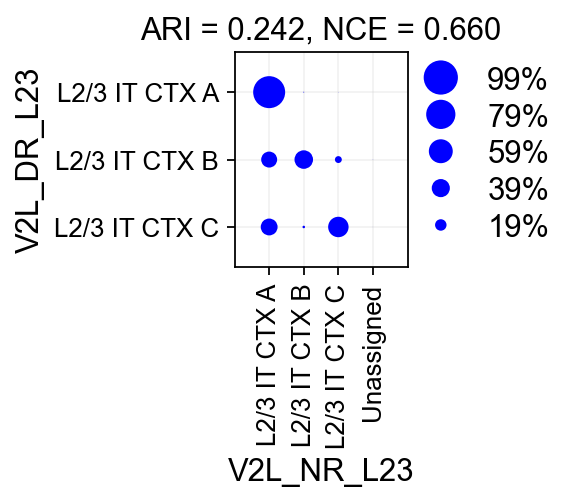

In [5]:
nr_dict = {'L2/3 IT CTX A':0, 'L2/3 IT CTX B':1,'L2/3 IT CTX C':2}
dr_dict = {'L2/3 IT CTX A':0, 'L2/3 IT CTX B':1,'L2/3 IT CTX C':2}


validation_label_train_70nrvsdr, valid_predlabels_train_70nrvsdr, test_labelsnrvsdr, test_predlabelsnrvsdr = tm.xgbclassifier(
    train_anndata = nr,
    test_anndata = dr,
    train_dict = nr_dict,
    test_dict = dr_dict
    )


mappingconfmatnrvsdr, mappingxticksnrvsdr, mappingplotnrvsdr = tm.plotConfusionMatrix(
    ytrue = test_labelsnrvsdr,
    ypred = test_predlabelsnrvsdr,
    type = 'mapping',
    save_as = 'V2L_nrvsdr_L23_mapping.pdf',
    title = 'ARI = {:.3f}, NCE = {:.3f}'.format(adjusted_rand_score(labels_true = test_labelsnrvsdr, labels_pred = test_predlabelsnrvsdr), calculateNCE(labels_true = test_labelsnrvsdr, labels_pred = test_predlabelsnrvsdr)),
    xaxislabel = 'V2L_NR_L23',
    yaxislabel = 'V2L_DR_L23'
    )

In [6]:
mappingconfmatnrvsdr

array([[0.98909091, 0.008     , 0.00290909, 0.        ],
       [0.39173884, 0.47768155, 0.12791472, 0.00266489],
       [0.42065491, 0.03358522, 0.5440806 , 0.00167926]])

In [10]:
import seaborn as sns
sns.set_theme(style="ticks")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['t-test_bh']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


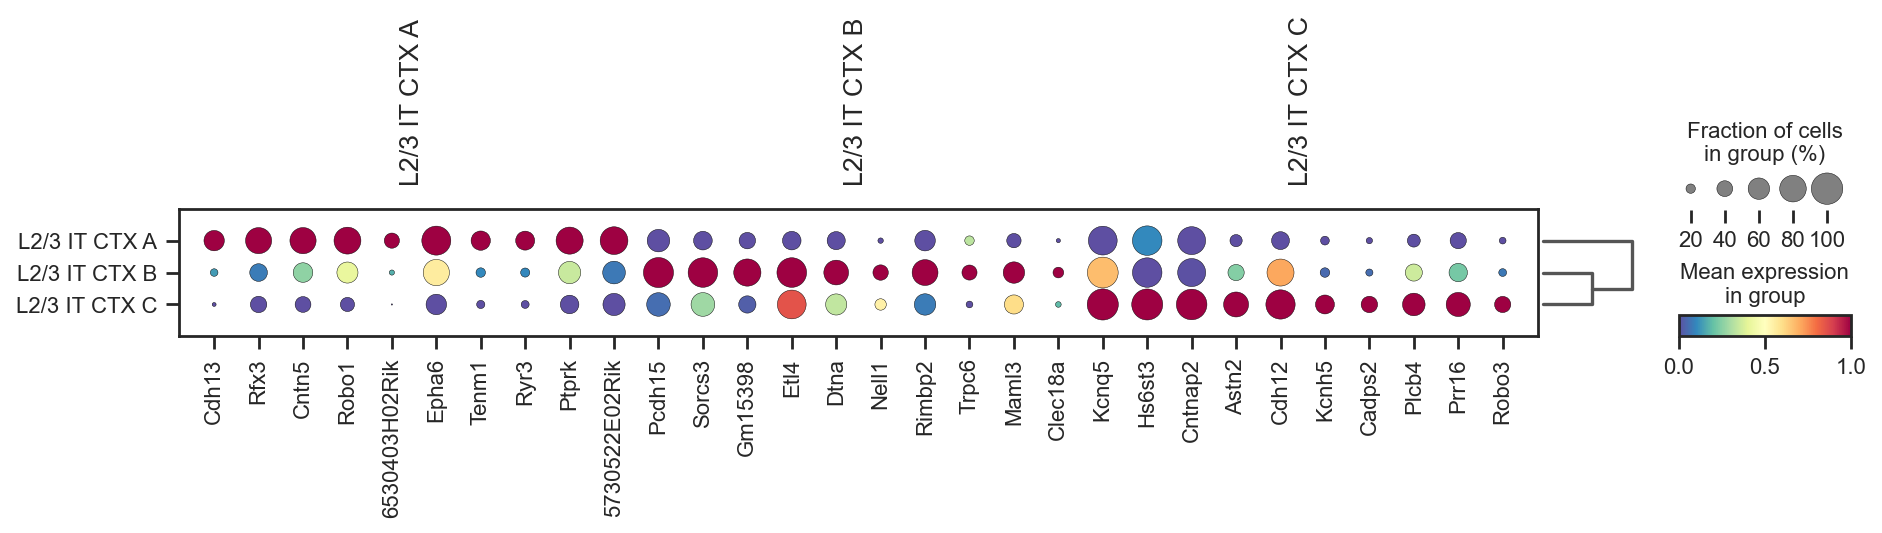

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['t-test_bh']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


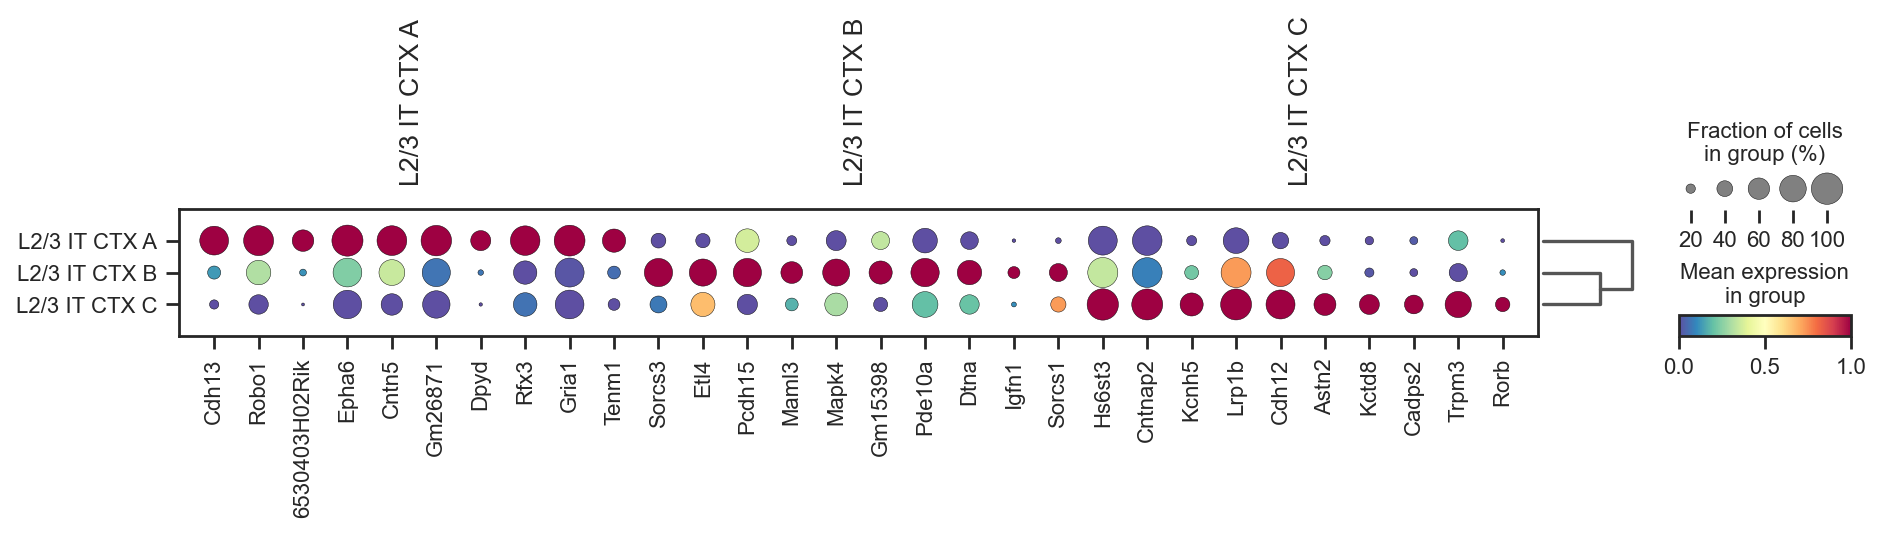

In [22]:
sc.tl.dendrogram(nr, groupby='Type')
sc.tl.rank_genes_groups(nr, groupby='Type',groups='all', reference='rest', method='t-test',pts=True,corr_method='benjamini-hochberg',key_added='t-test_bh')
sc.pl.rank_genes_groups_dotplot(nr, n_genes=10,groupby='Type',cmap='Spectral_r', standard_scale='var',key='t-test_bh',min_logfoldchange=1)
sc.tl.dendrogram(dr, groupby='Type')
sc.tl.rank_genes_groups(dr, groupby='Type',groups='all', reference='rest', method='t-test',pts=True,corr_method='benjamini-hochberg',key_added='t-test_bh')
sc.pl.rank_genes_groups_dotplot(dr, n_genes=10,groupby='Type',cmap='Spectral_r', standard_scale='var',key='t-test_bh',min_logfoldchange=1)

In [23]:
set(nr.obs['Type'])

{'L2/3 IT CTX A', 'L2/3 IT CTX B', 'L2/3 IT CTX C'}

In [24]:
nr_0 = sc.get.rank_genes_groups_df(nr, group="L2/3 IT CTX A",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)
nr_1 = sc.get.rank_genes_groups_df(nr, group="L2/3 IT CTX B",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)
nr_2 = sc.get.rank_genes_groups_df(nr, group="L2/3 IT CTX C",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)
dr_0 = sc.get.rank_genes_groups_df(dr, group="L2/3 IT CTX A",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)
dr_1 = sc.get.rank_genes_groups_df(dr, group="L2/3 IT CTX B",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)
dr_2 = sc.get.rank_genes_groups_df(dr, group="L2/3 IT CTX C",key='t-test_bh', pval_cutoff=0.05, log2fc_min=1)

In [25]:
nr_0.to_csv('NR_markergene_A_filter.xls',index=True,sep='\t')
nr_1.to_csv('NR_markergene_B_filter.xls',index=True,sep='\t')
nr_2.to_csv('NR_markergene_C_filter.xls',index=True,sep='\t')
dr_0.to_csv('DR_markergene_A_filter.xls',index=True,sep='\t')
dr_1.to_csv('DR_markergene_B_filter.xls',index=True,sep='\t')
dr_2.to_csv('DR_markergene_C_filter.xls',index=True,sep='\t')

In [3]:
pc_lasso_df=pd.read_csv('V2L_L23_Lasso_PC1rank.xls',sep='\t')

In [19]:
nr.obs['Type'].value_counts()

Type
L2/3 IT CTX B    1702
L2/3 IT CTX A    1694
L2/3 IT CTX C     928
Name: count, dtype: int64

In [20]:
dr.obs['Type'].value_counts()

Type
L2/3 IT CTX B    1501
L2/3 IT CTX A    1375
L2/3 IT CTX C    1191
Name: count, dtype: int64

In [22]:
import seaborn as sns
sns.set_theme(style="ticks")

In [25]:
adata =  sc.AnnData.concatenate(nr,dr,batch_categories=('NR','DR'),batch_key='cond')

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1307/3039874168.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata =  sc.AnnData.concatenate(nr,dr,batch_categories=('NR','DR'),batch_key='cond')


In [26]:
adata.obs

,n_genes,n_counts,doublet_score,Sample,Class,Subclass,Subtype,Ann_subclass_cell,Type,cond
AAACGAAAGAAGCGCT-1-V2L_1-NR,579,762.0,0.021762,V2L_1,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGAACAGGTACGA-1-V2L_1-NR,1459,2697.0,0.040264,V2L_1,Glut,L2/3 IT CTX,Type C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,NR
AAACGAAGTAATTAGG-1-V2L_1-NR,1593,2891.0,0.053322,V2L_1,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
AAACGAATCTCGGCTT-1-V2L_1-NR,1286,2179.0,0.022246,V2L_1,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGCTCACCTTCCA-1-V2L_1-NR,1144,1933.0,0.072668,V2L_1,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGATCG-1-V2L_2-DR,1854,3630.0,0.028843,V2L_2,Glut,L2/3 IT CTX,Type A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,DR
TTTGGTTGTTCACGAT-1-V2L_2-DR,2420,5707.0,0.098200,V2L_2,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR
TTTGTTGCACTCTGCT-1-V2L_2-DR,2026,4249.0,0.039651,V2L_2,Glut,L2/3 IT CTX,Type C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,DR
TTTGTTGCAGCTTTGA-1-V2L_2-DR,2385,5681.0,0.024654,V2L_2,Glut,L2/3 IT CTX,Type B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR


In [27]:
def compute_egt(adata, conds, obs_id):
    #adata.X = adata.X
    typeX_objs = []
    for cond in conds:
        typeX_objs.append(adata[adata.obs[obs_id]==cond].X.todense())
    Egt = []
    thresh = []
    keep = []
    for gene in range(adata.shape[1]):

        Fgt = []
        Xgt = []

        for obj in typeX_objs:
            nonZ_cells = np.where(obj[:,gene]!=0)[0]
            Fgt.append(nonZ_cells.shape[0]/obj.shape[0])


            Xgt.append(np.mean(obj[nonZ_cells,gene]))


        Egt.append(np.array(Fgt)*np.array(Xgt))
        thresh.append((np.max(Egt[gene])-np.min(Egt[gene]))/np.max(Egt[gene]))

    adata.varm['Egt_cond'] = np.array(Egt)

    return adata

In [28]:
Subtype = []
for i in range(adata.shape[0]):
    if adata.obs['cond'][i] == 'NR':
        Subtype.append('NR '+adata.obs['Type'][i])
    elif adata.obs['cond'][i] == 'DR':
        Subtype.append('DR '+adata.obs['Type'][i])
adata.obs['Subtype'] = Subtype

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1307/3423196741.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['cond'][i] == 'NR':
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1307/3423196741.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Subtype.append('NR '+adata.obs['Type'][i])
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_1307/3423196741.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

In [29]:
adata.obs

,n_genes,n_counts,doublet_score,Sample,Class,Subclass,Subtype,Ann_subclass_cell,Type,cond
AAACGAAAGAAGCGCT-1-V2L_1-NR,579,762.0,0.021762,V2L_1,Glut,L2/3 IT CTX,NR L2/3 IT CTX A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGAACAGGTACGA-1-V2L_1-NR,1459,2697.0,0.040264,V2L_1,Glut,L2/3 IT CTX,NR L2/3 IT CTX C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,NR
AAACGAAGTAATTAGG-1-V2L_1-NR,1593,2891.0,0.053322,V2L_1,Glut,L2/3 IT CTX,NR L2/3 IT CTX B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
AAACGAATCTCGGCTT-1-V2L_1-NR,1286,2179.0,0.022246,V2L_1,Glut,L2/3 IT CTX,NR L2/3 IT CTX A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,NR
AAACGCTCACCTTCCA-1-V2L_1-NR,1144,1933.0,0.072668,V2L_1,Glut,L2/3 IT CTX,NR L2/3 IT CTX B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,NR
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGTGATCG-1-V2L_2-DR,1854,3630.0,0.028843,V2L_2,Glut,L2/3 IT CTX,DR L2/3 IT CTX A,007 L2/3 IT CTX Glut,L2/3 IT CTX A,DR
TTTGGTTGTTCACGAT-1-V2L_2-DR,2420,5707.0,0.098200,V2L_2,Glut,L2/3 IT CTX,DR L2/3 IT CTX B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR
TTTGTTGCACTCTGCT-1-V2L_2-DR,2026,4249.0,0.039651,V2L_2,Glut,L2/3 IT CTX,DR L2/3 IT CTX C,007 L2/3 IT CTX Glut,L2/3 IT CTX C,DR
TTTGTTGCAGCTTTGA-1-V2L_2-DR,2385,5681.0,0.024654,V2L_2,Glut,L2/3 IT CTX,DR L2/3 IT CTX B,007 L2/3 IT CTX Glut,L2/3 IT CTX B,DR


In [30]:
conds = ['NR L2/3 IT CTX A','NR L2/3 IT CTX B', 'NR L2/3 IT CTX C','DR L2/3 IT CTX A', 'DR L2/3 IT CTX B', 'DR L2/3 IT CTX C']
compute_egt(adata, conds, 'Subtype')
d=pd.DataFrame(adata.varm['Egt_cond'], columns = conds,index = adata.var.index)

/opt/anaconda3/lib/python3.11/site-packages/numpy/matrixlib/defmatrix.py:446: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [31]:
df = pd.read_csv('all_marker_gene_class.txt',sep='\t')

In [32]:
df

,Gene,Class,Type
0,Cdh13,Common,A
1,Rfx3,Common,A
2,Cntn5,Common,A
3,Robo1,Common,A
4,6530403H02Rik,Common,A
...,...,...,...
984,Triobp,DR_specific,C
985,Gm42707,DR_specific,C
986,Cfap52,DR_specific,C
987,Gm19519,DR_specific,C


In [33]:
df_with_values = df.copy()
df_with_values = df_with_values.set_index('Gene') 

df_with_values = df_with_values.join(d, how='left') 

df_with_values.reset_index(inplace=True)

In [34]:
df_with_values = df_with_values.sort_values(by=['Class', 'Type'], ascending=[True, True])

In [35]:
df_with_values.fillna(0, inplace=True)

In [36]:
df_with_values

,Gene,Class,Type,NR L2/3 IT CTX A,NR L2/3 IT CTX B,NR L2/3 IT CTX C,DR L2/3 IT CTX A,DR L2/3 IT CTX B,DR L2/3 IT CTX C
12,4930412B13Rik,Common,A,0.015393,0.000000,0.000000,0.071633,0.008615,0.002751
14,4930467D21Rik,Common,A,0.071676,0.024036,0.018711,0.156157,0.060938,0.066712
20,4930505G20Rik,Common,A,0.032889,0.006099,0.010250,0.060116,0.012470,0.006959
29,5730522E02Rik,Common,A,1.878519,1.182303,1.123524,2.140167,1.431892,1.501030
34,6530403H02Rik,Common,A,0.721027,0.141096,0.021016,1.203850,0.196826,0.062717
...,...,...,...,...,...,...,...,...,...
911,Tmc1,NR_specific,C,0.016469,0.077721,0.095000,0.003443,0.024030,0.030454
918,Tmem18,NR_specific,C,0.031466,0.027869,0.066913,0.040657,0.035056,0.052736
919,Tmem232,NR_specific,C,0.058291,0.109927,0.222616,0.082274,0.134272,0.187169
935,Trim32,NR_specific,C,0.032053,0.051206,0.093029,0.041942,0.044191,0.065392


In [37]:
df_with_values.index = list(df_with_values['Gene'])
del df_with_values['Gene']

In [38]:
df_with_values.to_csv('V2L_all_marker_class_exp.xls',index=True,sep='\t')

In [40]:
from scipy.stats import zscore


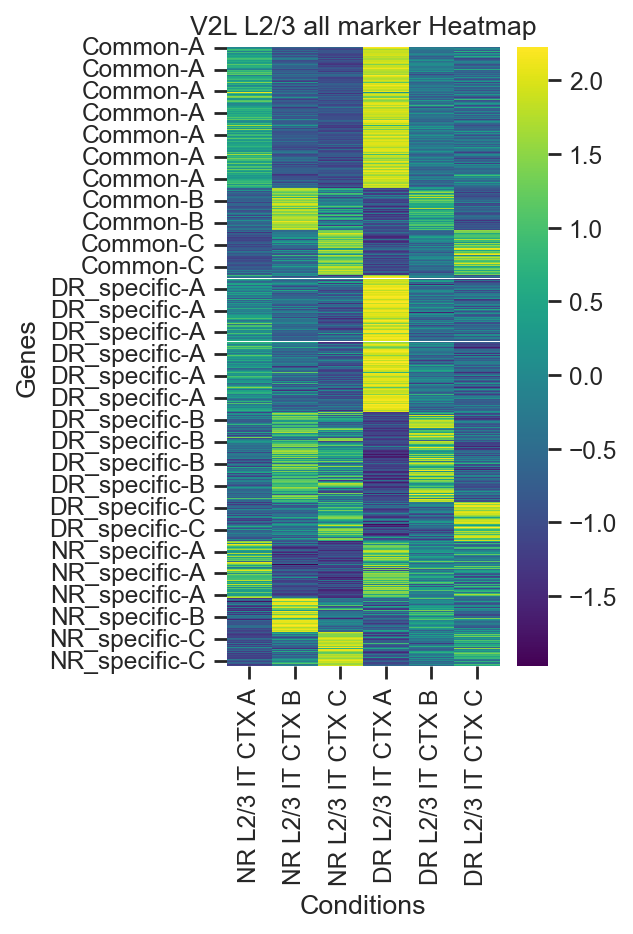

In [42]:
df_zscore = df_with_values.apply(zscore, axis=1)

plt.figure(figsize=(4,6))
sns.heatmap(df_zscore, cmap='viridis',fmt='.2f') 
plt.title('V2L L2/3 all marker Heatmap')
plt.xlabel('Conditions')
plt.ylabel('Genes')
plt.tight_layout()

plt.show()

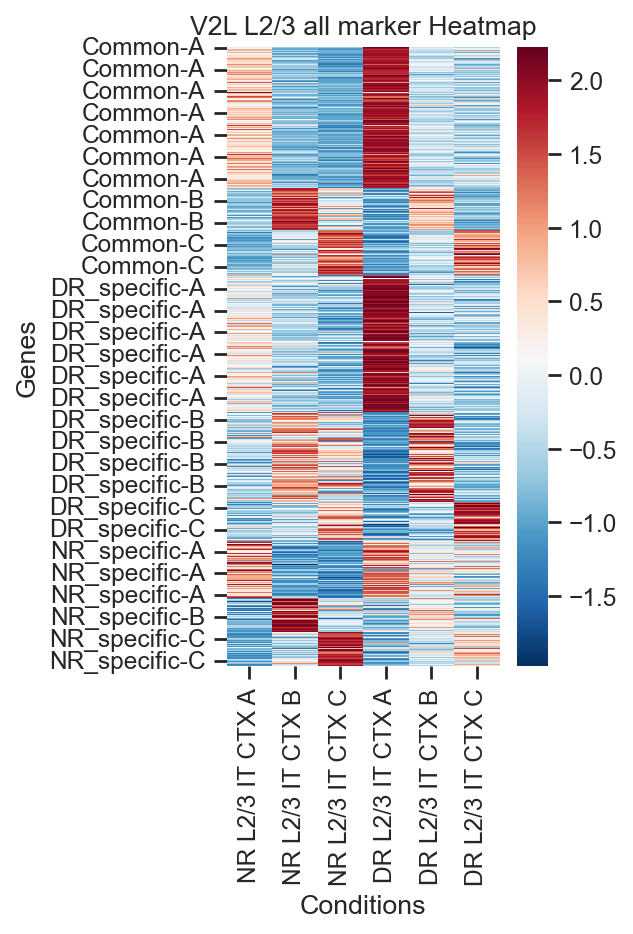

In [44]:
plt.figure(figsize=(4,6))
sns.heatmap(df_zscore, cmap='RdBu_r',fmt='.2f') 
plt.title('V2L L2/3 all marker Heatmap')
plt.xlabel('Conditions')
plt.ylabel('Genes')
plt.tight_layout()

plt.savefig('V2L_L23_all_marker_Heatmap.pdf')

PC1 解释的方差比例: 0.0217


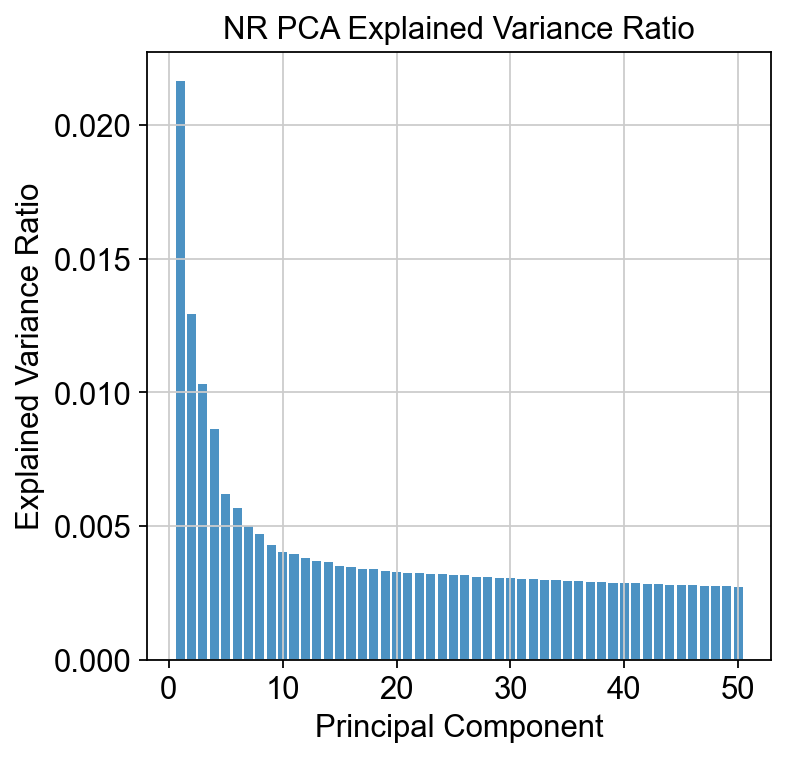

In [9]:
# Obtain the variance interpretation ratio of PCA
variance_ratio = nr.uns['pca']['variance_ratio']

# The variance ratio explained by the first principal component (PC1)
pc1_variance = variance_ratio[0]
print(f"PC1 解释的方差比例: {pc1_variance:.4f}")
# 绘制 PCA 的方差解释比例图
plt.figure(figsize=(5, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('NR PCA Explained Variance Ratio')
plt.savefig('NR_PC1_Explained_Variance.pdf')

DR PC1 解释的方差比例: 0.0290


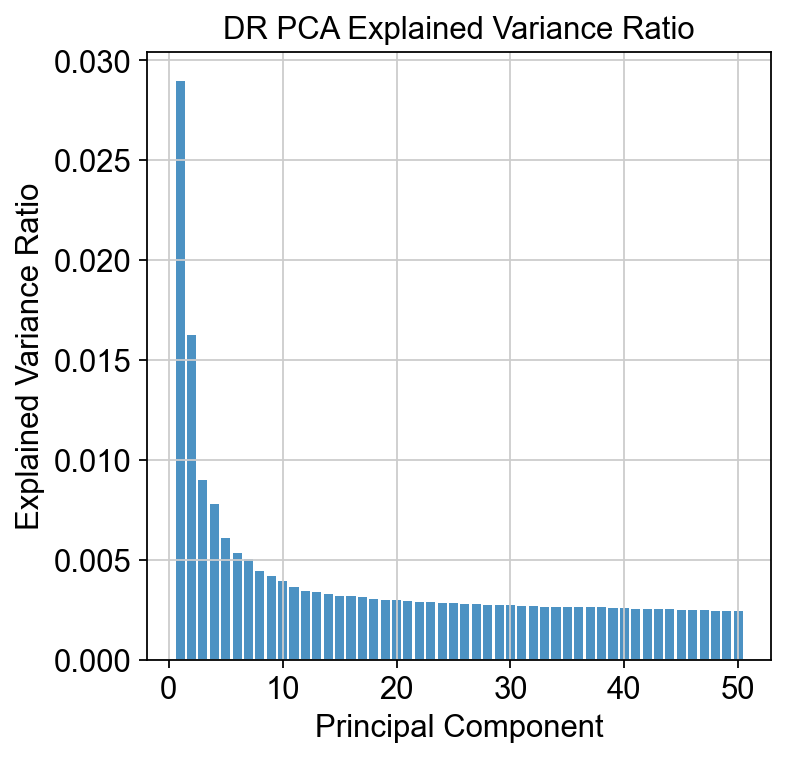

In [8]:

variance_ratio = dr.uns['pca']['variance_ratio']

pc1_variance = variance_ratio[0]
print(f"DR PC1 解释的方差比例: {pc1_variance:.4f}")

plt.figure(figsize=(5, 5))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('DR PCA Explained Variance Ratio')
plt.savefig('DR_PC1_Explained_Variance.pdf')

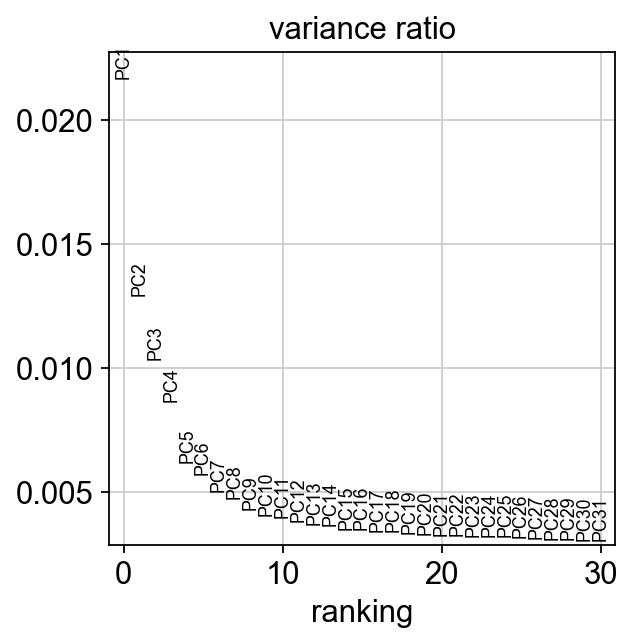

In [5]:
sc.pl.pca_variance_ratio(nr, n_pcs=30,log=False)